Over / Under with Nested Models

    - Last time, we explored the calibration of the individual team runs scored models

    - We observed some degree of mis-calibration: over-predicting the probability of low runs scored, under-predicting the probability of high runs scored

    - However, these discrepancies did not seem large enough to explain the high degree of miscalibration in the overall model

    - Concluded that the independence assumption must be flawed

    - In this notebook, we use nested modeling to predict the total runs scored

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli
import scipy as sp

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
# How unlikely is it that we would get 197 (or fewer) successes in 342 trials if the success probability is .7?

.7*(194+148)

239.39999999999998

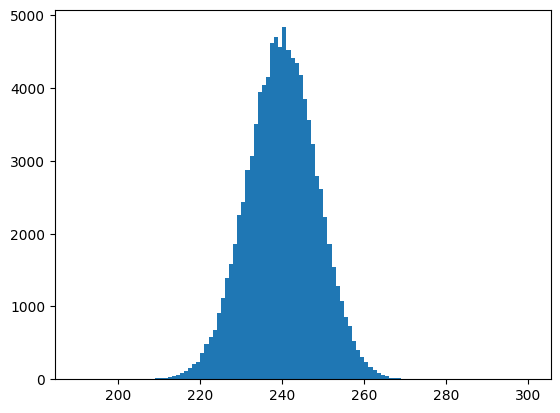

In [3]:
plt.hist(np.random.binomial(n=(194+148), p=.7, size=100000), bins=np.linspace(190,300,111));

In [4]:
df = pd.read_csv('df_bp9.csv', low_memory=False)

df_runs = pd.read_csv('df_runs_bp11.csv', low_memory=False)

In [5]:
df.over_under_line.max()

19.5

In [6]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],20)

Nested Modeling

    - Idea: use the outputs of one model as the inputs to a second model

    - Want to use the predicted distributions (and the over / under line) to predict probability of over / under (rather than relying on the independence assumption)

    - Problem: If we use our previous runs scored model and apply it to the training data, the predictions will be overconfident (or otherwise weird)

    - Need predicted distributions on the training set that are "credible" (i.e. predictions from a model that did not see that point in the training set)

    - We will use cross-validation to get these values.

    - We will create folds based on time.

In [7]:
fold_dict = {}
fold_dict[2000]=-1
for i in range(2001,2018,5):
    fold_dict[i]=0
for i in range(2002,2018,5):
    fold_dict[i]=1
for i in range(2003,2018,5):
    fold_dict[i]=2
for i in range(2004,2018,5):
    fold_dict[i]=3
for i in range(2005,2018,5):
    fold_dict[i]=4
fold_dict[2018] = 5 # validation set
for i in range(2018,2024):
    fold_dict[i]=6 # test set
df_runs['foldnum1'] = df_runs.season.apply(lambda x: fold_dict[x])

In [8]:
pd.crosstab(df_runs.season, df_runs.foldnum1)

foldnum1,-1,0,1,2,3,4,6
season,,,,,,,
2000,4858,0,0,0,0,0,0
2001,0,4858,0,0,0,0,0
2002,0,0,4852,0,0,0,0
2003,0,0,0,4860,0,0,0
2004,0,0,0,0,4856,0,0
2005,0,0,0,0,0,4862,0
2006,0,4858,0,0,0,0,0
2007,0,0,4862,0,0,0,0
2008,0,0,0,4856,0,0,0


In [9]:
df_runs.shape

(113542, 159)

In [10]:
df_runs.iloc[:5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_10,lineup9_BATAVG_10,lineup8_BATAVG_10_w,lineup9_BATAVG_10_w,lineup8_OBP_10,lineup9_OBP_10,lineup8_OBP_10_w,lineup9_OBP_10_w,lineup8_SLG_10,lineup9_SLG_10,lineup8_SLG_10_w,lineup9_SLG_10_w,lineup8_OBS_10,lineup9_OBS_10,lineup8_OBS_10_w,lineup9_OBS_10_w,lineup8_SLGmod_10,lineup9_SLGmod_10,lineup8_SLGmod_10_w,lineup9_SLGmod_10_w,lineup8_SObat_perc_10,lineup9_SObat_perc_10,lineup8_SObat_perc_10_w,lineup9_SObat_perc_10_w,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_81,lineup9_BATAVG_81,lineup8_BATAVG_81_w,lineup9_BATAVG_81_w,lineup8_OBP_81,lineup9_OBP_81,lineup8_OBP_81_w,lineup9_OBP_81_w,lineup8_SLG_81,lineup9_SLG_81,lineup8_SLG_81_w,lineup9_SLG_81_w,lineup8_OBS_81,lineup9_OBS_81,lineup8_OBS_81_w,lineup9_OBS_81_w,lineup8_SLGmod_81,lineup9_SLGmod_81,lineup8_SLGmod_81_w,lineup9_SLGmod_81_w,lineup8_SObat_perc_81,lineup9_SObat_perc_81,lineup8_SObat_perc_81_w,lineup9_SObat_perc_81_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,Strt_ERA_6,Strt_WHIP_6,Strt_SO_perc_6,Strt_H_BB_perc_6,Strt_TB_BB_perc_6,Strt_FIP_6,Strt_FIP_perc_6,Strt_ERA_15,Strt_WHIP_15,Strt_SO_perc_15,Strt_H_BB_perc_15,Strt_TB_BB_perc_15,Strt_FIP_15,Strt_FIP_perc_15,Strt_ERA_30,Strt_WHIP_30,Strt_SO_perc_30,Strt_H_BB_perc_30,Strt_TB_BB_perc_30,Strt_FIP_30,Strt_FIP_perc_30,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_30,Bpen_SO_perc_30,Bpen_H_BB_perc_30,Bpen_TB_BB_perc_30,Bpen_WHIP_162,Bpen_SO_perc_162,Bpen_H_BB_perc_162,Bpen_TB_BB_perc_162,home_hitting,runs_trunc,foldnum1
0,2000,20000329,0,200003290,NYN,CHN,NL,NL,0.0,NaN,TOK01,N,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237860,0.251431,0.238568,0.250346,0.334452,0.344910,0.334292,0.343436,0.382455,0.384404,0.381870,0.383628,0.716907,0.729314,0.716162,0.727065,0.402844,0.389830,0.399184,0.388178,0.147286,0.146794,0.145588,0.145323,0.245549,0.254750,0.246067,0.254049,0.346180,0.352160,0.347118,0.352248,0.389000,0.397188,0.389727,0.396804,0.735181,0.749348,0.736845,0.749051,0.408938,0.412390,0.409787,0.412717,0.151145,0.158055,0.151315,0.157331,0.294249,0.291099,0.296043,0.293119,0.373477,0.369210,0.375677,0.371739,0.461612,0.448858,0.464532,0.453115,0.835089,0.818068,0.840209,0.824854,0.399125,0.396081,0.400460,0.397673,0.137912,0.145276,0.137494,0.143963,0.293784,0.283775,0.294884,0.286040,0.371615,0.363083,0.373521,0.365888,0.459983,0.437337,0.461734,0.441796,0.831597,0.800420,0.835255,0.807684,0.396236,0.394088,0.397373,0.395387,0.137939,0.148280,0.137354,0.146438,3.941606,0.919708,0.275862,0.241379,0.402299,2.364964,0.620690,4.942373,1.250847,0.243373,0.296386,0.472289,3.945763,0.934940,4.192833,1.366894,0.212515,0.315230,0.460449,4.121160,0.950413,1.50,0.200000,0.370000,0.450000,1.50,0.200000,0.370000,0.450000,1.500000,0.200000,0.370000,0.450000,1,3,-1
1,2000,20000330,0,200003300,CHN,NYN,NL,NL,0.0,NaN,TOK01,N,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.255689,0.238390,0.254898,0.239873,0.348563,0.332

In [11]:
df_runs.iloc[56771:56776,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_10,lineup9_BATAVG_10,lineup8_BATAVG_10_w,lineup9_BATAVG_10_w,lineup8_OBP_10,lineup9_OBP_10,lineup8_OBP_10_w,lineup9_OBP_10_w,lineup8_SLG_10,lineup9_SLG_10,lineup8_SLG_10_w,lineup9_SLG_10_w,lineup8_OBS_10,lineup9_OBS_10,lineup8_OBS_10_w,lineup9_OBS_10_w,lineup8_SLGmod_10,lineup9_SLGmod_10,lineup8_SLGmod_10_w,lineup9_SLGmod_10_w,lineup8_SObat_perc_10,lineup9_SObat_perc_10,lineup8_SObat_perc_10_w,lineup9_SObat_perc_10_w,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_81,lineup9_BATAVG_81,lineup8_BATAVG_81_w,lineup9_BATAVG_81_w,lineup8_OBP_81,lineup9_OBP_81,lineup8_OBP_81_w,lineup9_OBP_81_w,lineup8_SLG_81,lineup9_SLG_81,lineup8_SLG_81_w,lineup9_SLG_81_w,lineup8_OBS_81,lineup9_OBS_81,lineup8_OBS_81_w,lineup9_OBS_81_w,lineup8_SLGmod_81,lineup9_SLGmod_81,lineup8_SLGmod_81_w,lineup9_SLGmod_81_w,lineup8_SObat_perc_81,lineup9_SObat_perc_81,lineup8_SObat_perc_81_w,lineup9_SObat_perc_81_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,Strt_ERA_6,Strt_WHIP_6,Strt_SO_perc_6,Strt_H_BB_perc_6,Strt_TB_BB_perc_6,Strt_FIP_6,Strt_FIP_perc_6,Strt_ERA_15,Strt_WHIP_15,Strt_SO_perc_15,Strt_H_BB_perc_15,Strt_TB_BB_perc_15,Strt_FIP_15,Strt_FIP_perc_15,Strt_ERA_30,Strt_WHIP_30,Strt_SO_perc_30,Strt_H_BB_perc_30,Strt_TB_BB_perc_30,Strt_FIP_30,Strt_FIP_perc_30,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_30,Bpen_SO_perc_30,Bpen_H_BB_perc_30,Bpen_TB_BB_perc_30,Bpen_WHIP_162,Bpen_SO_perc_162,Bpen_H_BB_perc_162,Bpen_TB_BB_perc_162,home_hitting,runs_trunc,foldnum1
56771,2000,20000329,0,200003290,NYN,CHN,NL,NL,0.0,NaN,TOK01,N,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256951,0.242894,0.257373,0.245061,0.339307,0.316099,0.341291,0.320839,0.416047,0.384312,0.415022,0.387419,0.755354,0.700411,0.756314,0.708258,0.425834,0.431659,0.424307,0.429540,0.173999,0.207806,0.171900,0.201615,0.238266,0.224755,0.238755,0.226913,0.312101,0.299645,0.313400,0.302400,0.395654,0.366507,0.395317,0.369906,0.707754,0.666152,0.708717,0.672307,0.431144,0.433239,0.430161,0.432086,0.191560,0.209164,0.190230,0.205727,0.259092,0.244707,0.260084,0.247431,0.326444,0.312120,0.327975,0.315323,0.422748,0.392922,0.423459,0.397354,0.749191,0.705042,0.751435,0.712677,0.412771,0.414919,0.412069,0.414012,0.174106,0.192484,0.172864,0.189027,0.256125,0.237954,0.258075,0.242024,0.326724,0.305854,0.329405,0.310926,0.429554,0.394514,0.432379,0.401517,0.756278,0.700368,0.761785,0.712444,0.409023,0.400956,0.409955,0.402823,0.158146,0.170410,0.157136,0.167939,2.817391,1.408696,0.208589,0.331288,0.380368,2.791304,0.656442,3.009554,1.404459,0.189066,0.334852,0.407745,3.372611,0.804100,2.674923,1.253870,0.182440,0.307868,0.378563,2.879257,0.706956,1.5,0.20,0.370000,0.4500,1.5,0.200000,0.370000,0.450000,1.5,0.200000,0.370000,0.450000,0,5,-1
56772,2000,20000330,0,200003300,CHN,NYN,NL,NL,0.0,NaN,TOK01,N,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.234953,0.231070,0.234582,0.231228,0.335407,0.320362,0

In [12]:
df_train = df_runs[(df_runs.season>2000) & (df_runs.season<=2017)]
df_valid = df_runs[(df_runs.season>=2018) & (df_runs.season<=2018)]
df_test = df_runs[df_runs.season>=2019]

df_test_game = df[df.season>=2019]

In [13]:
df_train.shape, df_valid.shape, df_test.shape

((82598, 159), (4862, 159), (21224, 159))

In [14]:
df_train.shape[0] /2,  df_valid.shape[0]/2, df_test.shape[0]/2

(41299.0, 2431.0, 10612.0)

In [15]:
df_train.iloc[:5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_10,lineup9_BATAVG_10,lineup8_BATAVG_10_w,lineup9_BATAVG_10_w,lineup8_OBP_10,lineup9_OBP_10,lineup8_OBP_10_w,lineup9_OBP_10_w,lineup8_SLG_10,lineup9_SLG_10,lineup8_SLG_10_w,lineup9_SLG_10_w,lineup8_OBS_10,lineup9_OBS_10,lineup8_OBS_10_w,lineup9_OBS_10_w,lineup8_SLGmod_10,lineup9_SLGmod_10,lineup8_SLGmod_10_w,lineup9_SLGmod_10_w,lineup8_SObat_perc_10,lineup9_SObat_perc_10,lineup8_SObat_perc_10_w,lineup9_SObat_perc_10_w,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_81,lineup9_BATAVG_81,lineup8_BATAVG_81_w,lineup9_BATAVG_81_w,lineup8_OBP_81,lineup9_OBP_81,lineup8_OBP_81_w,lineup9_OBP_81_w,lineup8_SLG_81,lineup9_SLG_81,lineup8_SLG_81_w,lineup9_SLG_81_w,lineup8_OBS_81,lineup9_OBS_81,lineup8_OBS_81_w,lineup9_OBS_81_w,lineup8_SLGmod_81,lineup9_SLGmod_81,lineup8_SLGmod_81_w,lineup9_SLGmod_81_w,lineup8_SObat_perc_81,lineup9_SObat_perc_81,lineup8_SObat_perc_81_w,lineup9_SObat_perc_81_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,Strt_ERA_6,Strt_WHIP_6,Strt_SO_perc_6,Strt_H_BB_perc_6,Strt_TB_BB_perc_6,Strt_FIP_6,Strt_FIP_perc_6,Strt_ERA_15,Strt_WHIP_15,Strt_SO_perc_15,Strt_H_BB_perc_15,Strt_TB_BB_perc_15,Strt_FIP_15,Strt_FIP_perc_15,Strt_ERA_30,Strt_WHIP_30,Strt_SO_perc_30,Strt_H_BB_perc_30,Strt_TB_BB_perc_30,Strt_FIP_30,Strt_FIP_perc_30,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_30,Bpen_SO_perc_30,Bpen_H_BB_perc_30,Bpen_TB_BB_perc_30,Bpen_WHIP_162,Bpen_SO_perc_162,Bpen_H_BB_perc_162,Bpen_TB_BB_perc_162,home_hitting,runs_trunc,foldnum1
2429,2001,20010401,0,200104010,TOR,TEX,AL,AL,0.0,NaN,SJU01,D,8,0.248016,0.315266,0.394841,0.710108,22.0,6.0,4.0,0.275145,0.336611,0.469262,0.805873,100.0,89.0,34.0,0.226124,0.224568,0.225056,0.223801,0.295188,0.293253,0.294157,0.292568,0.396724,0.379579,0.397036,0.382040,0.691911,0.672832,0.691193,0.674608,0.382011,0.370430,0.383229,0.373000,0.140162,0.143107,0.140089,0.142667,0.258919,0.258433,0.258075,0.257732,0.326510,0.324129,0.326133,0.324092,0.451848,0.435986,0.450740,0.437001,0.778358,0.760115,0.776874,0.761093,0.426779,0.412316,0.425439,0.412943,0.160068,0.162057,0.158560,0.160442,0.281854,0.276337,0.282480,0.277603,0.347847,0.340668,0.348490,0.342160,0.507768,0.481621,0.508049,0.485196,0.855615,0.822289,0.856538,0.827357,0.451751,0.433990,0.451151,0.435706,0.154924,0.158584,0.154566,0.157795,0.285451,0.284118,0.286010,0.284792,0.351105,0.347190,0.351725,0.348247,0.508301,0.490156,0.507786,0.491996,0.859406,0.837345,0.859512,0.840243,0.449875,0.432990,0.448993,0.434338,0.156347,0.158104,0.156328,0.157863,9.450000,1.800000,0.117188,0.375000,0.593750,6.712500,1.398438,5.339552,1.466418,0.146096,0.329975,0.528967,5.283582,1.188917,4.645161,1.451613,0.144068,0.326877,0.502421,4.962366,1.117433,2.097561,0.130000,0.430000,0.690000,1.788991,0.140873,0.386905,0.575397,1.688660,0.171004,0.380576,0.538569,1,8,0
2430,2001,20010402,0,200104020,BAL,BOS,AL,AL,0.0,NaN,BAL12,D,2,0.261209,0.325623,0.390838,0.716461,17.0,26.0,15

In [18]:
df_train.iloc[41299:41299+5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_10,lineup9_BATAVG_10,lineup8_BATAVG_10_w,lineup9_BATAVG_10_w,lineup8_OBP_10,lineup9_OBP_10,lineup8_OBP_10_w,lineup9_OBP_10_w,lineup8_SLG_10,lineup9_SLG_10,lineup8_SLG_10_w,lineup9_SLG_10_w,lineup8_OBS_10,lineup9_OBS_10,lineup8_OBS_10_w,lineup9_OBS_10_w,lineup8_SLGmod_10,lineup9_SLGmod_10,lineup8_SLGmod_10_w,lineup9_SLGmod_10_w,lineup8_SObat_perc_10,lineup9_SObat_perc_10,lineup8_SObat_perc_10_w,lineup9_SObat_perc_10_w,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_81,lineup9_BATAVG_81,lineup8_BATAVG_81_w,lineup9_BATAVG_81_w,lineup8_OBP_81,lineup9_OBP_81,lineup8_OBP_81_w,lineup9_OBP_81_w,lineup8_SLG_81,lineup9_SLG_81,lineup8_SLG_81_w,lineup9_SLG_81_w,lineup8_OBS_81,lineup9_OBS_81,lineup8_OBS_81_w,lineup9_OBS_81_w,lineup8_SLGmod_81,lineup9_SLGmod_81,lineup8_SLGmod_81_w,lineup9_SLGmod_81_w,lineup8_SObat_perc_81,lineup9_SObat_perc_81,lineup8_SObat_perc_81_w,lineup9_SObat_perc_81_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,Strt_ERA_6,Strt_WHIP_6,Strt_SO_perc_6,Strt_H_BB_perc_6,Strt_TB_BB_perc_6,Strt_FIP_6,Strt_FIP_perc_6,Strt_ERA_15,Strt_WHIP_15,Strt_SO_perc_15,Strt_H_BB_perc_15,Strt_TB_BB_perc_15,Strt_FIP_15,Strt_FIP_perc_15,Strt_ERA_30,Strt_WHIP_30,Strt_SO_perc_30,Strt_H_BB_perc_30,Strt_TB_BB_perc_30,Strt_FIP_30,Strt_FIP_perc_30,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_30,Bpen_SO_perc_30,Bpen_H_BB_perc_30,Bpen_TB_BB_perc_30,Bpen_WHIP_162,Bpen_SO_perc_162,Bpen_H_BB_perc_162,Bpen_TB_BB_perc_162,home_hitting,runs_trunc,foldnum1
59200,2001,20010401,0,200104010,TOR,TEX,AL,AL,0.0,NaN,SJU01,D,1,0.289896,0.361630,0.430595,0.792225,29.0,18.0,8.0,0.283463,0.350193,0.446176,0.796368,135.0,69.0,47.0,0.249755,0.222004,0.250797,0.226471,0.314386,0.285010,0.316654,0.290790,0.435632,0.387228,0.439811,0.397152,0.750018,0.672238,0.756466,0.687942,0.418379,0.388559,0.424286,0.397682,0.165670,0.158373,0.167360,0.160826,0.302937,0.280388,0.303126,0.283423,0.378784,0.353364,0.380020,0.357709,0.523936,0.484240,0.524240,0.489558,0.902721,0.837604,0.904260,0.847267,0.477654,0.461618,0.478925,0.464803,0.173887,0.178640,0.173882,0.178032,0.294211,0.266322,0.294553,0.270174,0.373418,0.339472,0.373946,0.344262,0.512775,0.463345,0.511861,0.468800,0.886193,0.802816,0.885808,0.813061,0.469966,0.435580,0.467841,0.438030,0.165135,0.159132,0.163873,0.158756,0.300026,0.269091,0.300643,0.273578,0.380921,0.342369,0.382175,0.348399,0.523271,0.468902,0.523530,0.476044,0.904192,0.811271,0.905705,0.824443,0.473176,0.429517,0.472567,0.434514,0.160901,0.149196,0.159817,0.149704,2.531250,1.101562,0.144509,0.271676,0.387283,3.656250,0.901734,3.896907,1.350515,0.159036,0.315663,0.426506,3.896907,0.910843,4.865347,1.479208,0.152086,0.335128,0.491252,4.948515,1.121131,1.621622,0.150943,0.377358,0.610063,1.505747,0.176152,0.355014,0.552846,1.582349,0.156534,0.363332,0.514122,0,1,0
59201,2001,20010402,0,200104020,BAL,BOS,AL,AL,0.0,NaN,BAL12,D,1,0.262597,0.330106,0.419574,0.749679,27.0,6.0,

In [19]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_15',
 'Strt_TB_BB_perc_15',
 'Strt_H_BB_perc_15',
 'Strt_SO_perc_6',
 'Bpen_WHIP_162',
 'Bpen_TB_BB_perc_162',
 'Bpen_H_BB_perc_162',
 'Bpen_SO_perc_162',
 'Bpen_WHIP_30',
 'Bpen_TB_BB_perc_30',
 'Bpen_H_BB_perc_30',
 'Bpen_SO_perc_30',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']

In [28]:
bpv2 = np.linspace(-.5,20.5,22)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5])

In [29]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

Now, we will do "nested" prediction to create the run distribution values

In [30]:
run_dist_train = np.zeros((df_train.shape[0], 21))

In [31]:
# Loop to get cross-validated predictions on the training set
# *** CAN TAKE 60-90 MINUTES TO LOOP THROUGH ALL 5 TIMES ***

model_list = []
preds_list = []
for fn in range(5):
    tr_mask = df_train.foldnum1!=fn
    te_mask = df_train.foldnum1==fn
    X_tr = df_train.loc[tr_mask,feat_set]
    X_te = df_train.loc[te_mask,feat_set]
    y_tr = df_train[target][tr_mask]
    y_te = df_train[target][te_mask]
    model_list.append(stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2))
    model_list[fn].fit(X_tr, y_tr, eval_set=(X_te, y_te), early_stop_past_steps=5, eval_freq=10)
    run_dist_train[te_mask,:] = model_list[fn].predict_distributions(X_te).probmat

i=0, eval_set_loss = 2.4679336653817687
i=10, eval_set_loss = 2.464566579502937
i=20, eval_set_loss = 2.4619265105397594
i=30, eval_set_loss = 2.4599420129348477
i=40, eval_set_loss = 2.458465706365129
i=50, eval_set_loss = 2.457350347091195
i=60, eval_set_loss = 2.4564256505921853
i=70, eval_set_loss = 2.455507889071296
i=80, eval_set_loss = 2.4547636654052796
i=90, eval_set_loss = 2.4542002992754375
i=100, eval_set_loss = 2.4536824127996852
i=110, eval_set_loss = 2.4533103835638865
i=120, eval_set_loss = 2.4529958617354155
i=130, eval_set_loss = 2.452797961205342
i=140, eval_set_loss = 2.452633885060868
i=150, eval_set_loss = 2.4524662968526387
i=160, eval_set_loss = 2.452460443609321
i=170, eval_set_loss = 2.4524036271193626
i=180, eval_set_loss = 2.452340393722153
i=190, eval_set_loss = 2.452261951489744
i=200, eval_set_loss = 2.452270047102286
i=210, eval_set_loss = 2.452230266563576
i=220, eval_set_loss = 2.452212338728427
i=230, eval_set_loss = 2.452177311062783
i=240, eval_set_

In [32]:
# Redo previous approach to get predictions on valid, test sets

cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', structured_loss=False,
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)


i=0, eval_set_loss = 2.458969528056459


i=10, eval_set_loss = 2.4561356058079915
i=20, eval_set_loss = 2.454164316711808
i=30, eval_set_loss = 2.4528537897628415
i=40, eval_set_loss = 2.4518890971959437
i=50, eval_set_loss = 2.4511659067128893
i=60, eval_set_loss = 2.4507929801682184
i=70, eval_set_loss = 2.45030547954334
i=80, eval_set_loss = 2.449978329394033
i=90, eval_set_loss = 2.449887024218985
i=100, eval_set_loss = 2.4499227193762323
i=110, eval_set_loss = 2.4498637084396155
i=120, eval_set_loss = 2.4498633071963396
i=130, eval_set_loss = 2.4499368715604186
i=140, eval_set_loss = 2.450100272368312
i=150, eval_set_loss = 2.4501765827925603
i=160, eval_set_loss = 2.450224345419153
i=170, eval_set_loss = 2.4503103511801
Stopping early: low pt was 5 steps ago


In [33]:
run_dist_valid = cr1.predict_distributions(X_valid).probmat
run_dist_test = cr1.predict_distributions(X_test).probmat

In [34]:
cr1.predict_distributions(X_test).log_loss(y_test)

2.463896532514582

In [35]:
run_cdf_train = np.cumsum(run_dist_train, axis=1)[:,:-1]
run_cdf_valid = np.cumsum(run_dist_valid, axis=1)[:,:-1]
run_cdf_test = np.cumsum(run_dist_test, axis=1)[:,:-1]

In [36]:
result_probs = np.array([run_dist_train[i,y_train[i]] for i in range(len(y_train))])

In [37]:
-np.mean(np.log(result_probs))

2.4420808638217673

In [38]:
run_cdf_train1 = run_cdf_train[:41299,:]
run_cdf_train2 = run_cdf_train[41299:,:]
run_cdf_valid1 = run_cdf_valid[:2431,:]
run_cdf_valid2 = run_cdf_valid[2431:,:]
run_cdf_test1 = run_cdf_test[:10612,:]
run_cdf_test2 = run_cdf_test[10612:,:]

run_train_team1 = y_train[:41299]
run_train_team2 = y_train[41299:]
run_valid_team1 = y_valid[:2431]
run_valid_team2 = y_valid[2431:]
run_test_team1 = y_test[:10612]
run_test_team2 = y_test[10612:]

run_total_train = run_train_team1 + run_train_team2
run_total_valid = run_valid_team1 + run_valid_team2
run_total_test = run_test_team1 + run_test_team2

run_total_train = np.minimum(run_total_train, 20)
run_total_valid = np.minimum(run_total_valid, 20)
run_total_test = np.minimum(run_total_test, 20)

base_cols = ['rd'+str(i) for i in range(20)]
cn1 = [cn+'_h' for cn in base_cols]
cn2 = [cn+'_v' for cn in base_cols]
cn_list = cn1+cn2

In [39]:
X_train_nested = pd.DataFrame(np.hstack((run_cdf_train1, run_cdf_train2)))
X_valid_nested = pd.DataFrame(np.hstack((run_cdf_valid1, run_cdf_valid2)))
X_test_nested = pd.DataFrame(np.hstack((run_cdf_test1, run_cdf_test2)))

X_train_nested.columns = cn1+cn2
X_valid_nested.columns = cn1+cn2
X_test_nested.columns = cn1+cn2

In [40]:
run_cdf_train1.shape, run_cdf_train2.shape, X_train_nested.shape

((41299, 20), (41299, 20), (41299, 40))

In [41]:
X_train_nested.sample(10)

,rd0_h,rd1_h,rd2_h,rd3_h,rd4_h,rd5_h,rd6_h,rd7_h,rd8_h,rd9_h,rd10_h,rd11_h,rd12_h,rd13_h,rd14_h,rd15_h,rd16_h,rd17_h,rd18_h,rd19_h,rd0_v,rd1_v,rd2_v,rd3_v,rd4_v,rd5_v,rd6_v,rd7_v,rd8_v,rd9_v,rd10_v,rd11_v,rd12_v,rd13_v,rd14_v,rd15_v,rd16_v,rd17_v,rd18_v,rd19_v
34435,0.067942,0.180570,0.320929,0.467843,0.604736,0.715842,0.804175,0.869038,0.913367,0.945381,0.966311,0.979668,0.988306,0.993167,0.995906,0.997846,0.998816,0.999279,0.999558,0.999766,0.067816,0.181667,0.318245,0.460284,0.593758,0.699436,0.790356,0.858988,0.905798,0.939560,0.961739,0.976354,0.985454,0.991079,0.994524,0.996834,0.998348,0.999067,0.999460,0.999744
19106,0.061839,0.176459,0.314424,0.468272,0.606318,0.711848,0.801843,0.863082,0.910285,0.940577,0.961380,0.975869,0.985661,0.991286,0.994640,0.996380,0.997570,0.998519,0.999132,0.999437,0.044187,0.128497,0.239008,0.369358,0.495622,0.609909,0.709010,0.788094,0.852718,0.900517,0.933899,0.958491,0.973552,0.983193,0.989857,0.993903,0.996299,0.997930,0.998831,0.999191
33415,0.067075,0.179717,0.334874,0.490050,0.627837,0.740163,0.822253,0.883957,0.927294,0.954721,0.971321,0.982489,0.989513,0.993413,0.996103,0.997814,0.998659,0.999212,0.999532,0.999727,0.082564,0.216745,0.377799,0.529422,0.663164,0.768519,0.846054,0.900324,0.936408,0.962465,0.976695,0.986429,0.991742,0.994838,0.996806,0.998349,0.999087,0.999377,0.999642,0.999811
27967,0.068322,0.183106,0.332377,0.481798,0.623656,0.737370,0.821207,0.880493,0.922646,0.950503,0.968914,0.981259,0.988932,0.993412,0.996395,0.998019,0.998872,0.999319,0.999599,0.999743,0.084203,0.216670,0.379757,0.528472,0.656184,0.754991,0.830205,0.884775,0.922807,0.950005,0.968301,0.979880,0.987278,0.992105,0.995582,0.997458,0.998545,0.999001,0.999423,0.999662
26107,0.067692,0.184761,0.331512,0.482212,0.619960,0.734604,0.820897,0.880911,0.923748,0.951993,0.969660,0.982086,0.989553,0.993778,0.996478,0.998063,0.998899,0.999382,0.999630,0.999797,0.076656,0.209858,0.362755,0.513178,0.642602,0.745239,0.825617,0.880933,0.921697,0.948397,0.967144,0.979931,0.987999,0.992658,0.995696,0.997470,0.998607,0.999125,0.999454,0.999684
15402,0.044700,0.128783,0.241657,0.372296,0.505750,0.628296,0.731219,0.811364,0.870466,0.913385,0.943165,0.964708,0.978587,0.987844,0.993007,0.995970,0.997725,0.998614,0.999168,0.999456,0.060011,0.163985,0.295093,0.438943,0.568310,0.678535,0.768556,0.838194,0.887931,0.924515,0.951765,0.969244,0.981483,0.988899,0.993335,0.995965,0.997547,0.998368,0.998971,0.999354
30302,0.037161,0.109950,0.209601,0.332717,0.462615,0.585602,0.692916,0.776120,0.840095,0.887105,0.925973,0.951577,0.968092,0.979325,0.987382,0.992162,0.995341,0.997186,0.998264,0.998878,0.052604,0.151946,0.272999,0.410913,0.542710,0.655840,0.753880,0.825139,0.878998,0.915524,0.945146,0.964532,0.978046,0.985786,0.991387,0.994775,0.996973,0.998167,0.998946,0.999340
25192,0.068395,0.181854,0.326422,0.472631,0.603391,0.714293,0.803720,0.866126,0.912360,0.942860,0.963536,0.978049,0.987006,0.991947,0.995375,0.997167,0.998232,0.999034,0.999446,0.999678,0.079151,0.215189,0.381822,0.534378,0.663802,0.766911,0.842169,0.895580,0.931639,0.957757,0.972925,0.984192,0.990215,0.993866,0.996283,0.997755,0.998775,0.999176,0.999527,0.999700
23973,0.072829,0.194479,0.348834,0.500886,0.635612,0.747869,0.831147,0.889652,0.928914,0.955696,0.973496,0.984432,0.991239,0.994870,0.996956,0.998230,0.998948,0.999337,0.999546,0.999766,0.069672,0.189891,0.329844,0.483824,0.617114,0.718196,0.804205,0.869220,0.913577,0.944376,0.965988,0.979032,0.987263,0.992112,0.995068,0.997088,0.998414,0.999084,0.999443,0.999705
17304,0.037512,0.110622,0.208396,0.334111,0.466145,0.590590,0.696930,0.779019,0.843205,0.892837,0.927851,0.955055,0.971685,0.981215,0.988931,0.992736,0.995948,0.997774,0.998791,0.999264,0.045024,0.125085,0.227605,0.352083,0.481952,0.598705,0.707492,0.789765,0.856718,0.904149,0.938454,0.961806,0.976220,0.985261,0.991277,0.995028,0.997208,0.998291,0.998915,0.999266


In [42]:
cr_final = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', structured_loss=False,
               binpt_vec=bpv2)
cr_final.fit(X_train_nested, run_total_train, eval_set=(X_valid_nested, run_total_valid), early_stop_past_steps=5,)

i=0, eval_set_loss = 2.8064360578146825


i=10, eval_set_loss = 2.805034667430124
i=20, eval_set_loss = 2.8040781800144723
i=30, eval_set_loss = 2.8036449185723584
i=40, eval_set_loss = 2.8034727763947824
i=50, eval_set_loss = 2.803905798080794
i=60, eval_set_loss = 2.804519592204419
i=70, eval_set_loss = 2.8047532977392153
i=80, eval_set_loss = 2.804553253524107
i=90, eval_set_loss = 2.805163480994619
Stopping early: low pt was 5 steps ago


In [43]:
final_test_dists = cr_final.predict_distributions(X_test_nested)

In [44]:
final_test_dists.log_loss(run_total_test)

2.8076702441425234

In [45]:
start_test_dists = cr_final.predict_distributions(X_test_nested, num_trees_to_use=1)
start_test_dists.log_loss(run_total_test)

2.811828278903258

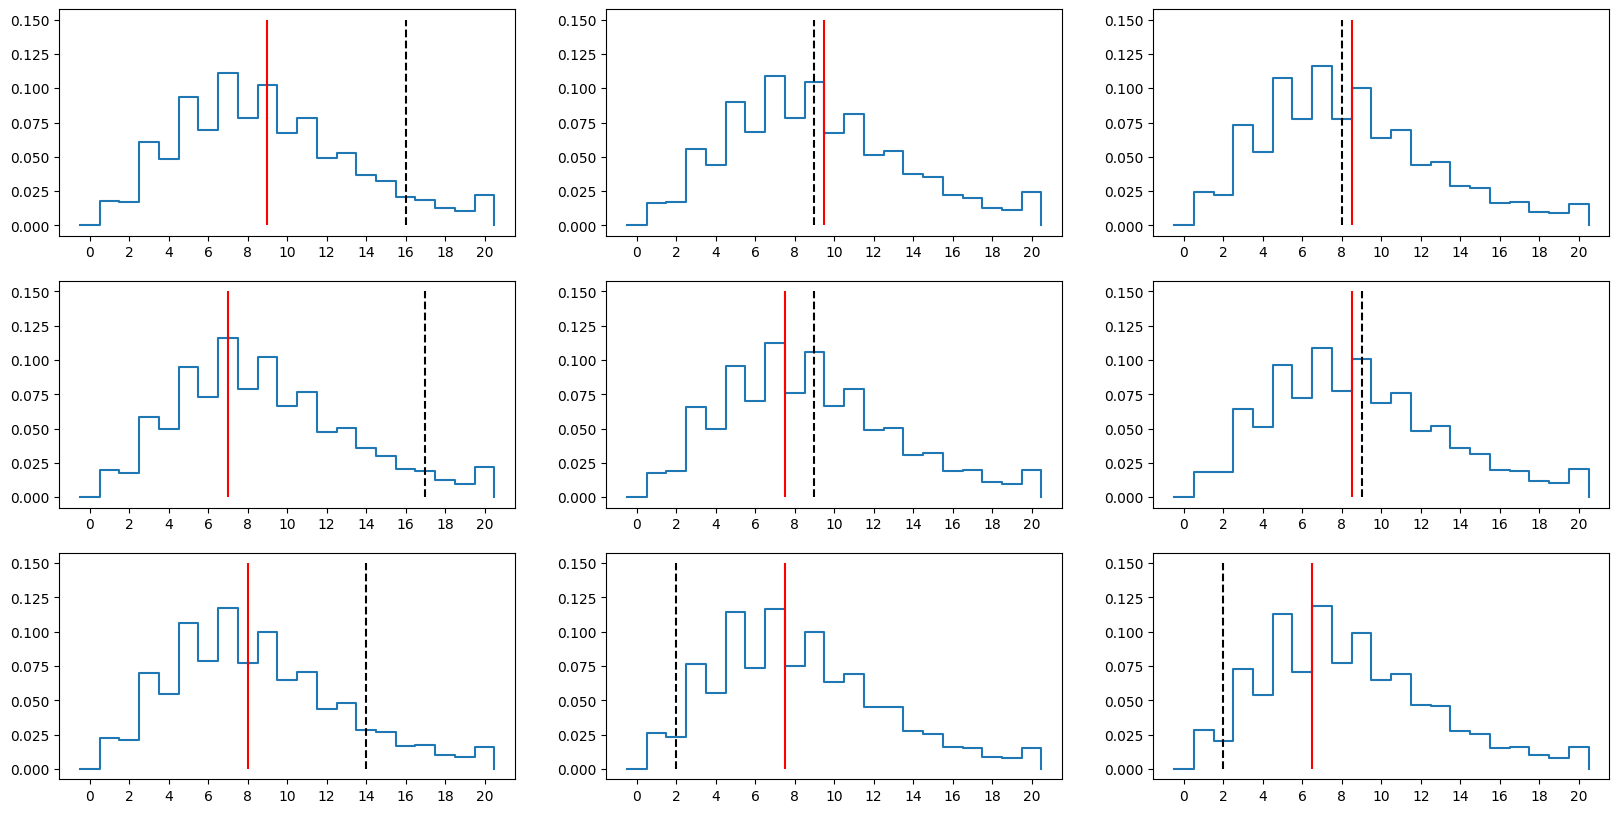

In [68]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    final_test_dists[i].plot_density()
    plt.vlines(run_total_test[i],ymin=0,ymax=.15, color='k', linestyle='--')
    plt.vlines(df_test_game.over_under_line.iloc[i],ymin=0,ymax=.15, color='red')
    plt.xticks(np.linspace(0,20,11))

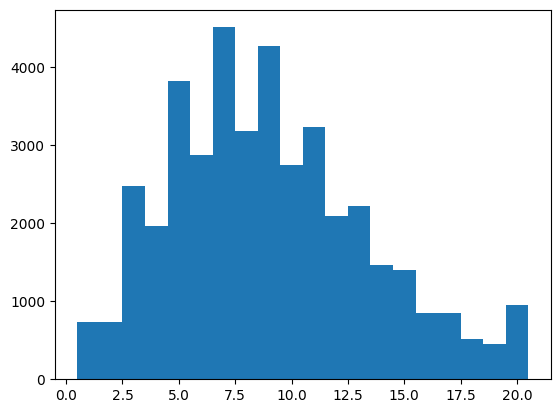

In [69]:
plt.hist(run_total_train, bins=np.linspace(0.5, 20.5, 21));

In [51]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(df_test_game.over_under_line.iloc[i]))]) 
                    for i in range(len(run_total_test))])

In [52]:
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(df_test_game.over_under_line.iloc[i]+1)):]) 
                    for i in range(len(run_total_test))])

In [54]:
push_probs_test = 1-under_probs_test-over_probs_test

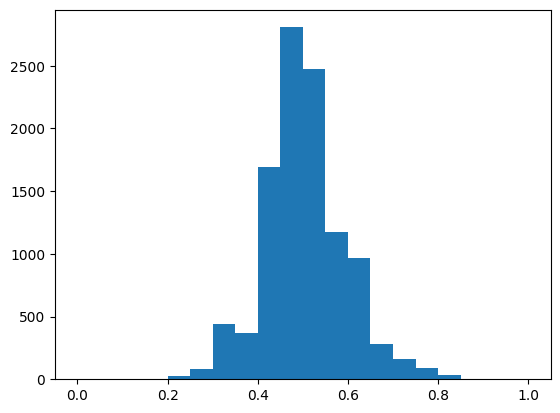

In [55]:
plt.hist(under_probs_test, bins=np.linspace(0,1,21));

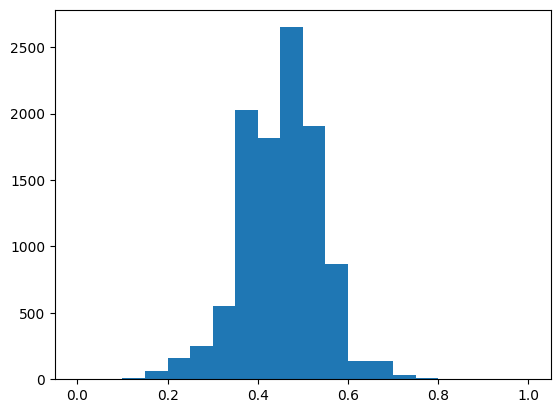

In [56]:
plt.hist(over_probs_test, bins=np.linspace(0,1,21));

Examine Calibration of Over/Under Predictions

In [66]:
np.linspace(0, 1, 51)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

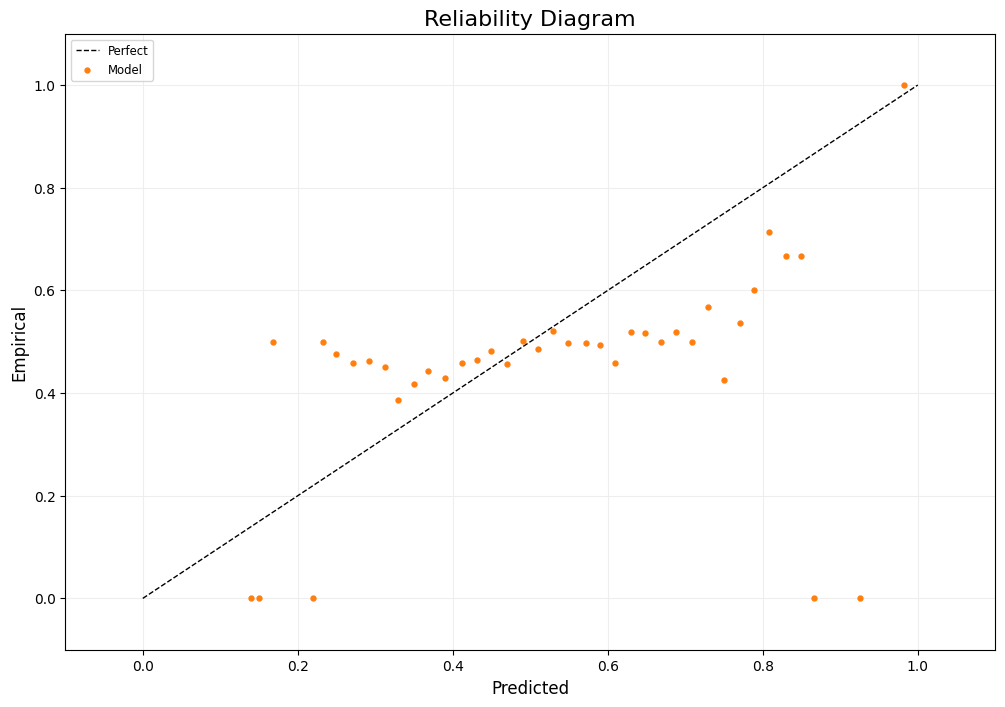

In [85]:
plt.figure(figsize=(12,8))
mli.plot_reliability_diagram((df_test_game.over_under_result=='U').astype(int), under_probs_test, np.linspace(0,1,51), 
                                                                                                        error_bars=False);
#plt.ylim([.3,.7])

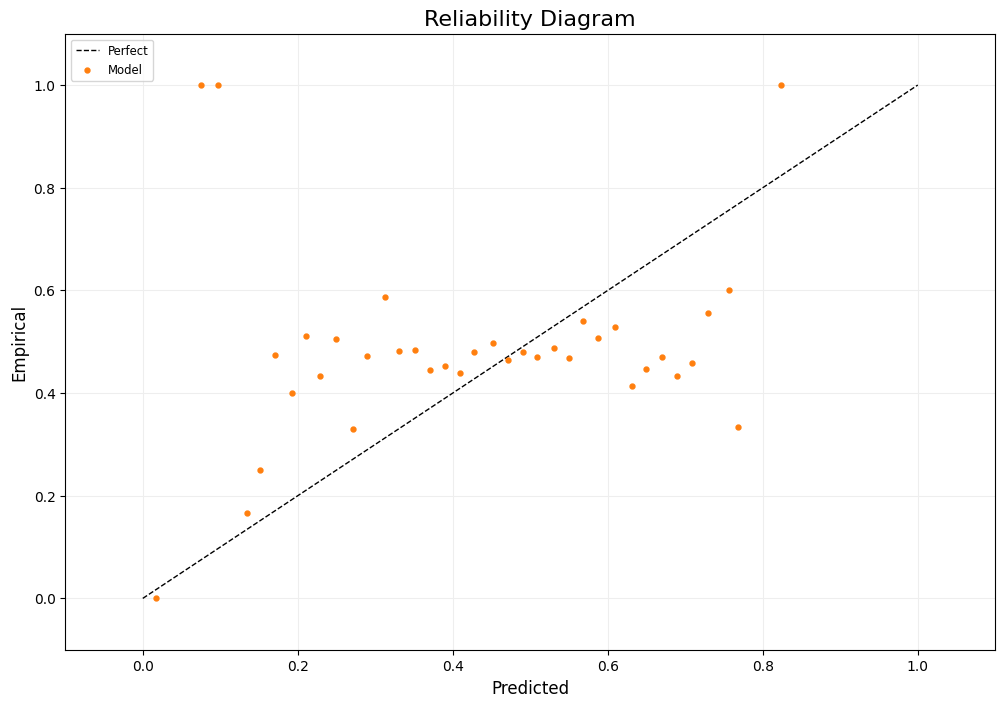

In [86]:
plt.figure(figsize=(12,8))
mli.plot_reliability_diagram((df_test_game.over_under_result=='O').astype(int), over_probs_test, np.linspace(0,1,51),
                                                                                                         error_bars=False);

(0.0, 0.2)

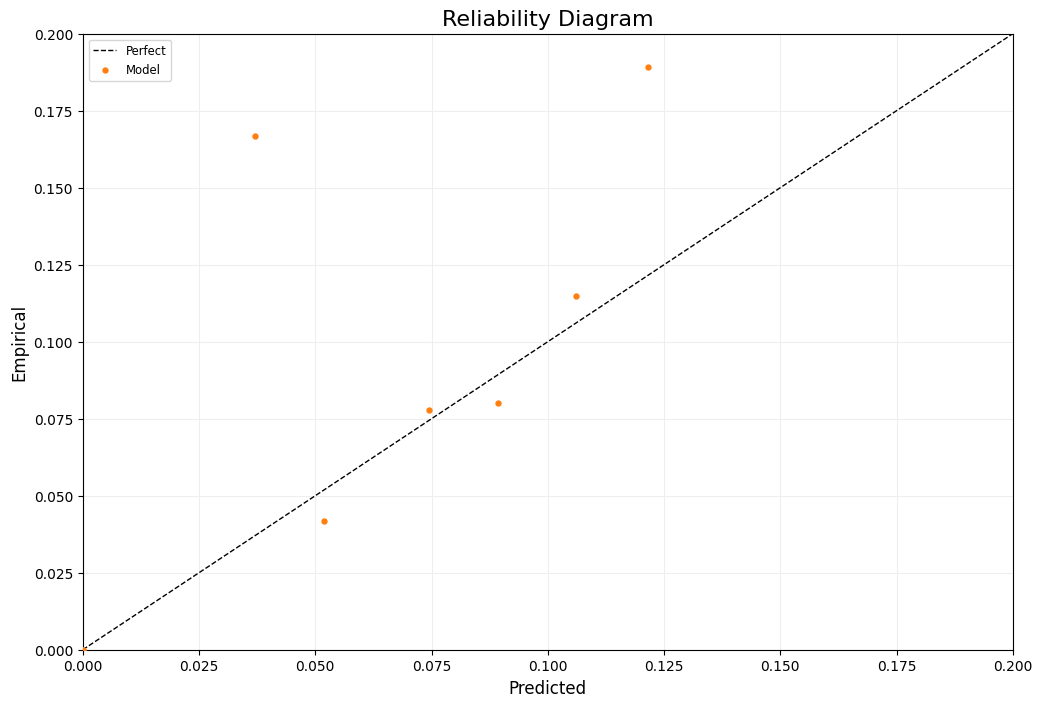

In [88]:
plt.figure(figsize=(12, 8))
mli.plot_reliability_diagram((df_test_game.over_under_result=='P').astype(int), push_probs_test, np.linspace(0,1,51),
                                                                                                        error_bars=False);
plt.xlim([0,.2])
plt.ylim([0,.2])

In [89]:
def evaluate_edge_probs(oupmat, edge, test_df_w_ouline):
    bet_under = (oupmat[:,1]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    bet_over = (oupmat[:,0]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    num_cases_under = np.sum(bet_under)
    num_cases_over = np.sum(bet_over)
    num_cases_total = num_cases_under + num_cases_over
    num_under_correct = (test_df_w_ouline.loc[bet_under,'over_under_result']=='U').sum()
    num_under_push = (test_df_w_ouline.loc[bet_under,'over_under_result']=='P').sum()
    num_over_correct = (test_df_w_ouline.loc[bet_over,'over_under_result']=='O').sum()
    num_over_push = (test_df_w_ouline.loc[bet_over,'over_under_result']=='P').sum()
    num_correct = num_under_correct + num_over_correct
    num_pushes = num_under_push + num_over_push
    num_incorrect = num_cases_total -num_correct - num_pushes
    pct_correct = num_correct / num_cases_total
    pct_pushes = num_pushes / num_cases_total
    pct_incorrect = num_incorrect / num_cases_total
    pct_under_correct = num_under_correct/num_cases_under
    pct_under_push = num_under_push/num_cases_under
    pct_over_correct = num_over_correct/num_cases_over
    pct_over_push = num_over_push/num_cases_over
    print(f'\nThere were {num_cases_total} games that met criteria of edge > {edge} ({num_cases_under} unders and {num_cases_over} overs)')
    print(f'Of them {num_correct} ({np.round(pct_correct,3)}) were correct (winning bets), ({num_under_correct} unders and {num_over_correct} overs) ')
    print(f'and {num_pushes} ({np.round(pct_pushes,3)}) were Pushes ({num_under_push} unders and {num_over_push} overs)')
    print(f'and {num_incorrect} ({np.round(pct_incorrect,3)}) were incorrect (losing bets))')
    winning_edge_m110 = pct_correct*1 + pct_incorrect*(-1.1)
    win_total_m110 = num_correct*1 + num_incorrect*(-1.1)
    print(f'Betting the Under at a line of -110, your profit would have been {np.round(winning_edge_m110,4)} per bet')
    print(f'\t for a total profit of {np.round(win_total_m110,2)} across all {num_cases_total} bets')
    print('\n')

In [90]:
oup_probs = np.vstack((over_probs_test, under_probs_test, push_probs_test)).T

In [91]:
for i in np.linspace(.25, .05,5):
    print(f'threshold = {i}')
    evaluate_edge_probs(oup_probs, i, df_test_game)

threshold = 0.25

There were 201 games that met criteria of edge > 0.25 (186 unders and 15 overs)
Of them 106 (0.527) were correct (winning bets), (99 unders and 7 overs) 
and 6 (0.03) were Pushes (4 unders and 2 overs)
and 89 (0.443) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.0403 per bet
	 for a total profit of 8.1 across all 201 bets


threshold = 0.2

There were 486 games that met criteria of edge > 0.2 (406 unders and 80 overs)
Of them 257 (0.529) were correct (winning bets), (218 unders and 39 overs) 
and 18 (0.037) were Pushes (13 unders and 5 overs)
and 211 (0.434) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.0512 per bet
	 for a total profit of 24.9 across all 486 bets


threshold = 0.15

There were 1035 games that met criteria of edge > 0.15 (785 unders and 250 overs)
Of them 511 (0.494) were correct (winning bets), (390 unders and 121 overs) 
and 36 (0.035) were Pushes (

Calibration with respect to fixed values

In [92]:
df_test_game.over_under_line.mean()

8.676309837919337

In [93]:
line = 8.5

In [94]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(line))]) 
                    for i in range(len(run_total_test))])

In [95]:
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(line))+1:]) 
                    for i in range(len(run_total_test))])

In [96]:
push_probs_test = 1-under_probs_test-over_probs_test

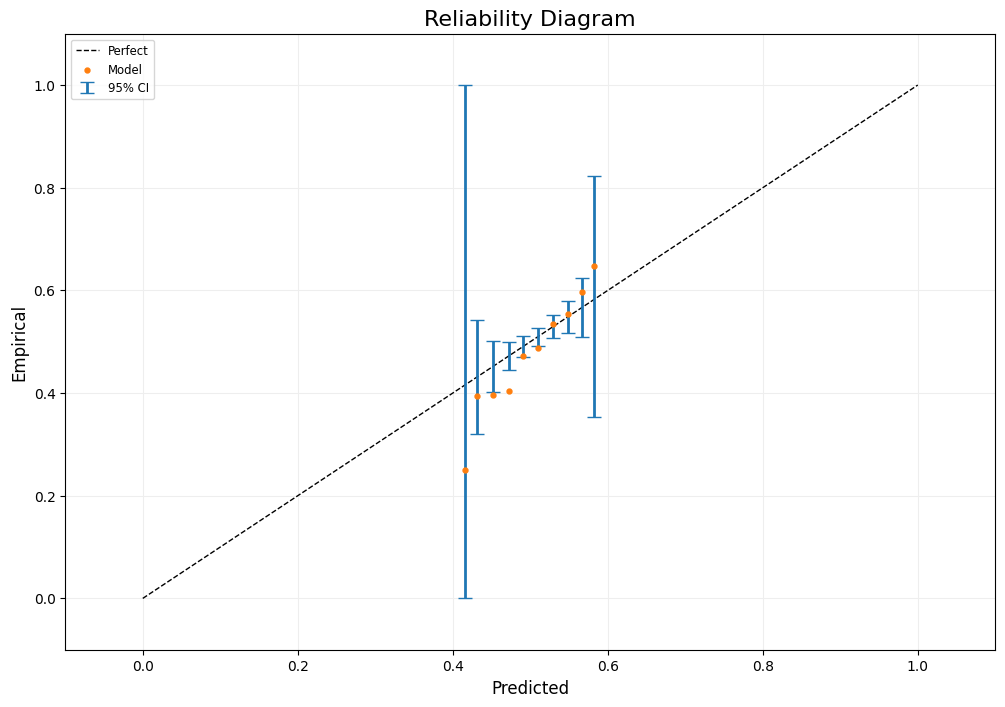

In [98]:
plt.figure(figsize=(12,8))
mli.plot_reliability_diagram((run_total_test<line).astype(int), under_probs_test, np.linspace(0,1,51));

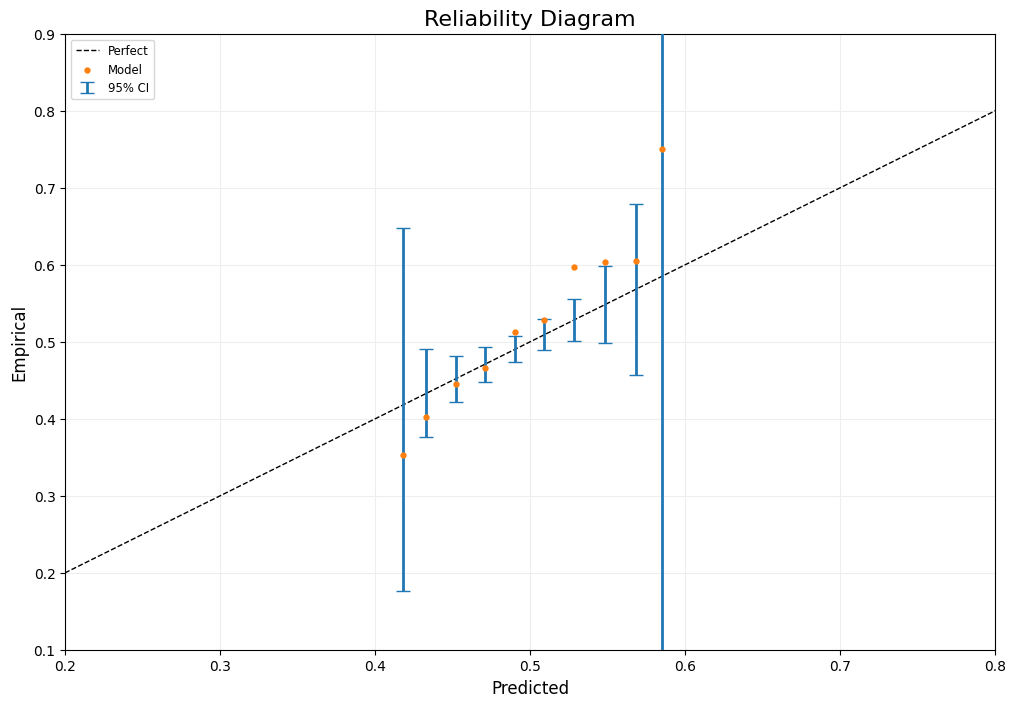

In [99]:
plt.figure(figsize=(12,8))
mli.plot_reliability_diagram((run_total_test>line).astype(int), over_probs_test, np.linspace(0,1,51));
plt.xlim([.2,.8]);
plt.ylim([.1,.9]);

Calibration with respect to randomly chosen line

(array([497., 516., 487., 498., 492., 515., 514., 498., 536., 494., 501.,
        494., 541., 492., 456., 490., 513., 561., 547., 510., 460.]),
 array([ 4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
         9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
        13.75, 14.25, 14.75, 15.25]),
 <BarContainer object of 21 artists>)

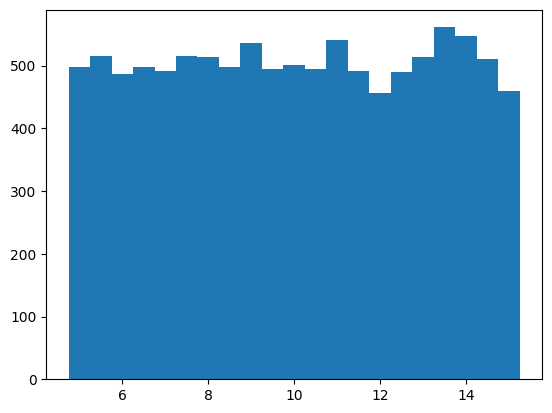

In [100]:
line = np.random.randint(10,31,size=len(run_total_test))/2
plt.hist(line, bins=np.linspace(4.75,15.25,22))

In [101]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(line[i]))]) 
                    for i in range(len(run_total_test))])

In [102]:
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(line[i]))+1:]) 
                    for i in range(len(run_total_test))])

In [103]:
push_probs_test = 1-under_probs_test-over_probs_test

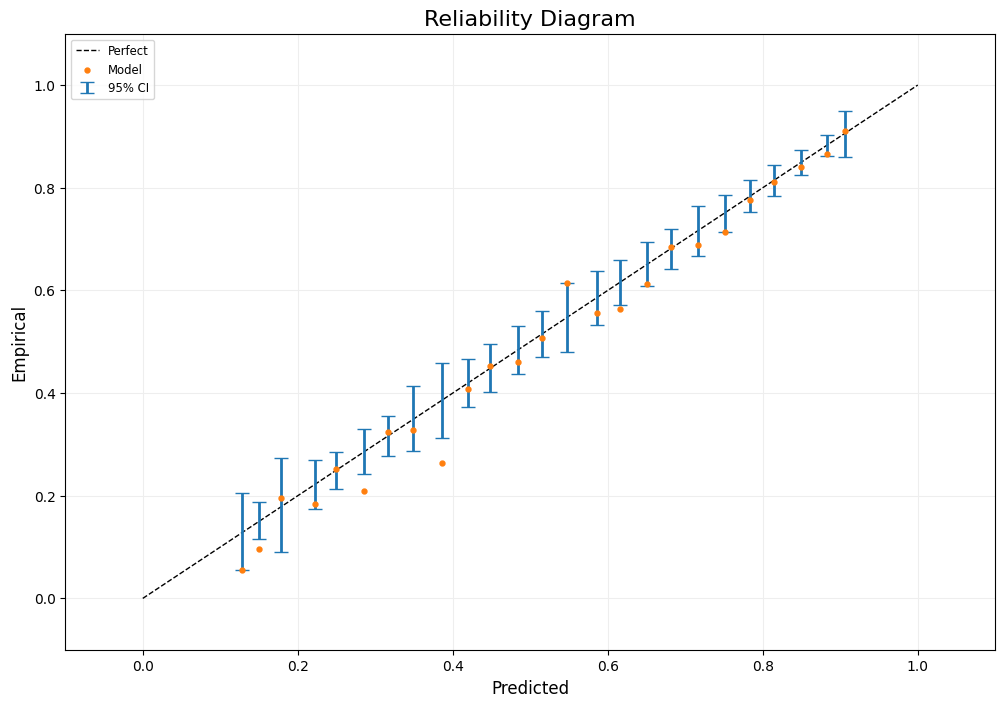

In [105]:
plt.figure(figsize=(12,8))
mli.plot_reliability_diagram((run_total_test<line).astype(int), under_probs_test, np.linspace(0,1,31));

(0.1, 0.9)

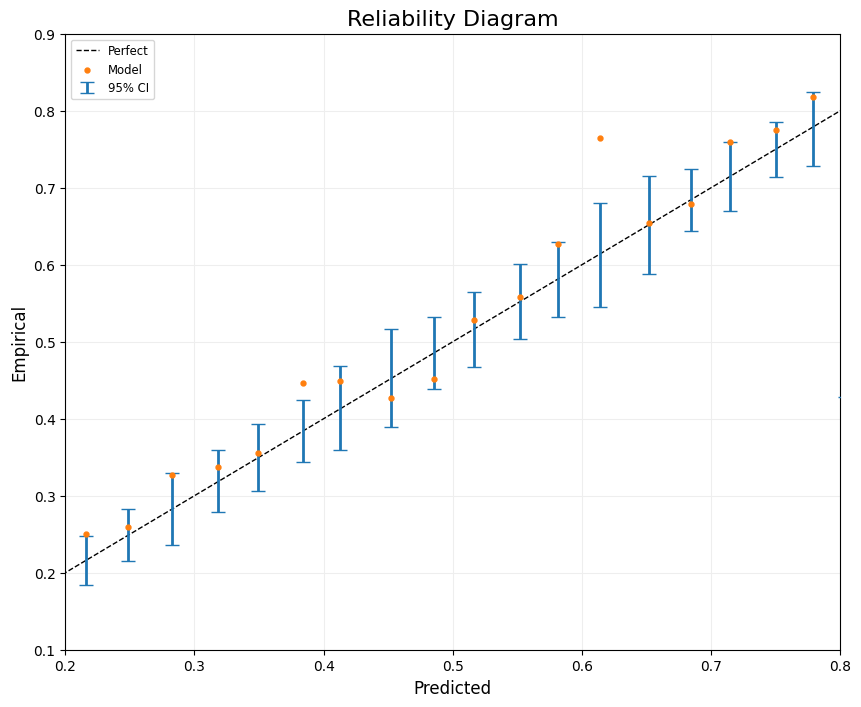

In [106]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test>line).astype(int), over_probs_test, np.linspace(0,1,31));
plt.xlim([.2,.8])
plt.ylim([.1,.9])

Conclusions

    - The information inherent in the Vegas line is likely the primary source of the overall miscalibration

    - Model tends to over-predict low scores and under-predict high scores.
        -- This is seen in both the individual team runs scored model and the combined model

    - Independence assumption seems less of a problem than before (could do more direct comparison)

Next Steps

    - Could try to dive deeper into the causes / solutions for the overprediction of low runs scored
        -- Might just be model drift
        -- Calibration / Conformal Prediction techniques will only help if there is a "good" data set to calibrate to

    - Predict run differential using similar techniques

    - Use all of the above to better predict the moneyline